In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
ML_data = pd.read_csv('ML_data.csv')

In [2]:
df = ML_data[['METHOD_MIC','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist']]

# creates features numpy array
features = df[df.columns[2:]].to_numpy()

#creates resistance label column
label = df['MUT_RESISTANCE'].to_numpy()

In [3]:
#no preprocessing - therefore, do not see why I would need a pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,4,6,8,10,12,14, None], 
              'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
              'max_features':['auto','sqrt','log2', None]}
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    random_state=0)

In [4]:
# creates features and label dfs from unique mutations
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MUT_RESISTANCE'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MUT_RESISTANCE']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [5]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [7]:
#Grid search with shuffled kfold validation
Kfold_shuffle=KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=Kfold_shuffle)
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold_shuffle.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6372695346795434
grid_kfold_shuffle: test set average accuracy:  0.6403508771929824 



In [8]:
#rogof score - look into - amino acid properties 

# up-sampling 
# 

In [9]:
from matplotlib import pyplot as plt
import numpy as np

#define trees with best perfoming parameters, or default parameters
tree_best_params = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.2,
                       min_samples_split=0.1, random_state=0)
tree_no_params = DecisionTreeClassifier(random_state=0)
tree_best_params.fit(X_train_cv, y_train_cv)    
tree_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('Feature importance plot')

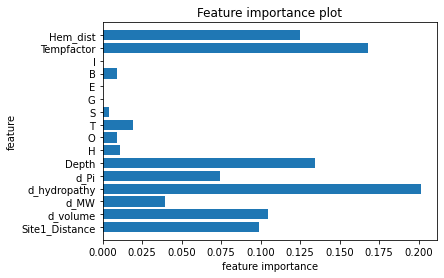

In [10]:
plot_feature_importances(tree_no_params)

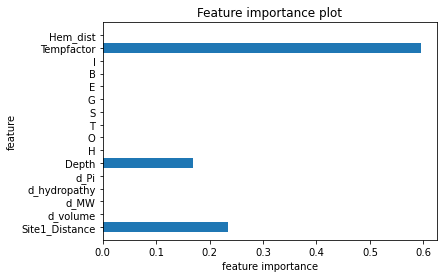

In [11]:
plot_feature_importances(tree_best_params)

In [12]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate average_precision
kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='average_precision')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set average precision: ', 
       average_precision_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6358122986606134
grid_kfold_shuffle test set average precision:  0.7002171371789321 



In [13]:
#Grid search with shuffled kfold validation
#use predict_proba function to calculate AUC

kfold_shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
grid_kfold_shuffle = GridSearchCV(tree, param_grid, cv=kfold_shuffle, scoring='roc_auc')
grid_kfold_shuffle.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold_shuffle.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold_shuffle.best_score_)                  
print ('grid_kfold_shuffle test set AUC: ', 
       roc_auc_score(y_test_cv, grid_kfold_shuffle.predict_proba(X_test_cv)[:,1]), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=6, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.6725072078991781
grid_kfold_shuffle test set AUC:  0.7032019704433498 



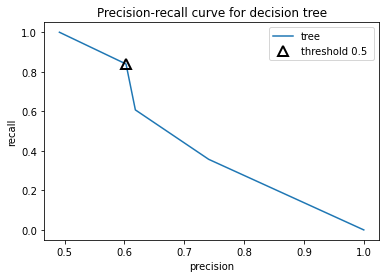

In [14]:
#use best parameters for average precision

from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.2, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)

precision, recall, thresholds = precision_recall_curve(y_test_cv, tree.predict_proba(X_test_cv)[:, 1])

plt.plot(precision, recall, label='tree')
close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(precision[close_default], recall[close_default], '^', c='k', 
          markersize=10, label='threshold 0.5 ', fillstyle='none', mew=2)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Precision-recall curve for decision tree')
plt.legend(loc='best')

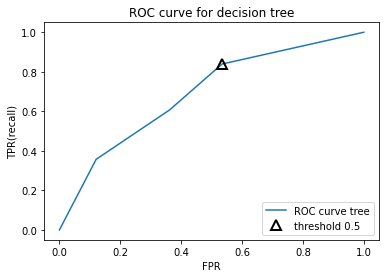

In [15]:
# use best parameters for AUC
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_cv, tree.predict_proba(X_test_cv)[:, 1])

plt.plot(fpr, tpr, label='ROC curve tree')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')

close_default = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default], tpr[close_default], '^', markersize=10, label='threshold 0.5', 
         fillstyle='none', c='k', mew=2)
plt.title('ROC curve for decision tree')
plt.legend(loc=4)

In [16]:
#confusion matrix (max_features=auto, max_depth=2, min_samples_lieaf=0.1, min_samples_split = 0)   
   
from sklearn.metrics import confusion_matrix

#build and fit decision tree
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.2, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)
predict = tree.predict(X_test_nodup).astype(int)

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

#calculate precision, sensitivty, specificity, FPR, errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7345132743362832
Sensitivity:  0.7217391304347827
Specificity:  0.6938775510204082
FPR : 0.30612244897959184
very major error : 30.612244897959183
major error:  27.82608695652174

 confusion matrix: 
 [[68 30]
 [32 83]]


{0: 100, 1: 113}


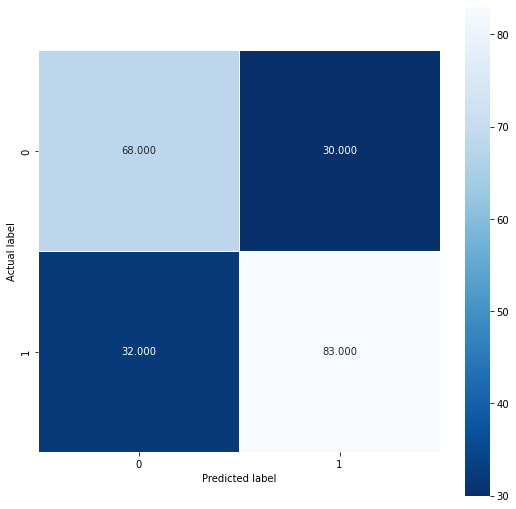

In [17]:
from sklearn import metrics
import seaborn as sns
unique, counts = np.unique(predict, return_counts=True)
print(dict(zip(unique, counts)))

cm = metrics.confusion_matrix(y_test_nodup, predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

In [18]:
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.2, min_samples_split=0.1,
                       random_state=0)
tree.fit(X_train_cv, y_train_cv)
predicted_proba = tree.predict_proba(X_test_nodup)
predict = (predicted_proba[:,1] >= 0.95).astype('int')

#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)
confusion

array([[ 98,   0],
       [115,   0]], dtype=int64)

Indirect binary classification via multiclass MIC classification

In [19]:
MIC_ML_data = ML_data.dropna(subset = ['METHOD_MIC'])

In [20]:
# need code to clean up values > 1.6 - need to see if RF can use continuous data

MIC_strings = []

for i in MIC_ML_data['METHOD_MIC']:
    if i == '3.2':
        MIC_strings.append('>1.6')
    elif i == '6.4':
        MIC_strings.append('>1.6')
    elif i == '12.8':
        MIC_strings.append('>1.6')
    elif i == '>12.8':
        MIC_strings.append('>1.6')
    else:
        MIC_strings.append(i)
        
MIC_ML_data['MIC_values'] = MIC_strings

C:\Users\user\AppData\Local\Temp/ipykernel_11004/380884722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIC_ML_data['MIC_values'] = MIC_strings


In [21]:
MIC_df = MIC_ML_data[['MIC_values','MUT_RESISTANCE','MUTATION','Site1_Distance','d_volume','d_MW',	\
              'd_hydropathy', 'd_Pi', 'Depth','H','O','T','S','G','E',  \
              'B','I','Tempfactor','Hem_dist']]

# creates features numpy array
MIC_features = MIC_df[MIC_df.columns[2:]].to_numpy()

#creates resistance label column
MIC_label = MIC_df['MIC_values'].to_numpy()

In [22]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(MIC_features, MIC_label,
                                                    random_state=0)

In [23]:
# creates features and label dfs from unique mutations when the original train-test split 
# is inputted 
def remove_duplicate_mutations(X_dataset, y_dataset):

    #converts long X_train and y_train to pd df to join
    X_train_df = pd.DataFrame(X_dataset)
    X_train_df.rename(columns = {0:'MUTATION'}, inplace = True)
    y_train_df = pd.DataFrame(y_dataset)
    y_train_df.rename(columns = {0:'MIC_VALUES'}, inplace = True)

    CV_train = X_train_df.join(y_train_df,  how = 'inner')

    #converts MIC_values to an integer so that the mean can be calculated for each mutation
    #with multiple samples
    MIC_integers = []

    for i in CV_train['MIC_VALUES']:
        if i == '<=0.025':
            MIC_integers.append(1)
        elif i == '0.05':
            MIC_integers.append(2)
        elif i == '0.1':
            MIC_integers.append(3)
        elif i == '0.2':
            MIC_integers.append(4)
        elif i == '0.4':
            MIC_integers.append(5)
        elif i == '0.8':
            MIC_integers.append(6)
        elif i == '1.6':
            MIC_integers.append(7)
        elif i == '>1.6':
            MIC_integers.append(8)
        
    CV_train['MIC_integers'] = MIC_integers

    #calculates the mean MIC value using the integer scale for each mutation
    MIC_calc_df = CV_train[['MUTATION','MIC_integers']].groupby('MUTATION').mean()
    
    #rounds the mean MIC value to the nearest integer for conversion back to the 
    #original MIC classes
    MIC_rounded = []
    for i in MIC_calc_df['MIC_integers']:
        rnd = round(i)
        MIC_rounded.append(rnd)
    MIC_calc_df['MIC_rounded'] = MIC_rounded
    
    #converts integers back to orignal MIC classes
    MIC_strings = []
    for i in MIC_calc_df['MIC_rounded']:
        if i == 1:
            MIC_strings.append('<=0.025')
        elif i == 2:
            MIC_strings.append('0.05')
        elif i == 3:
            MIC_strings.append('0.1')
        elif i == 4:
            MIC_strings.append('0.2')
        elif i == 5:
            MIC_strings.append('0.4')
        elif i == 6:
            MIC_strings.append('0.8')
        elif i == 7:
            MIC_strings.append('1.6')
        elif i == 8:
            MIC_strings.append('>1.6')   

    MIC_calc_df['MIC_final'] = MIC_strings

    # joins new MIC classes to CV_train df to replace the variation in MIC values associated
    # with mutations with multiple DST_measurements 
    MIC_calc_df.drop(['MIC_integers','MIC_rounded'], axis =1, inplace = True)
    CV_train.set_index('MUTATION', inplace = True)
    CV_train = CV_train.join(MIC_calc_df)
    CV_train.reset_index(inplace = True)
    CV_train.drop(['MIC_VALUES','MIC_integers'], axis = 1, inplace = True)
    CV_train.rename(columns = {'index':'MUTATION','MIC_final':'MIC_VALUES'}, inplace = True)
    
    #removes duplicates and mutation column
    CV_train_unique = CV_train.drop_duplicates(subset='MUTATION', keep = 'first')
    CV_train_unique.drop(['MUTATION'], axis = 1, inplace = True)

    #seperates into unique features and label numpy arrays
    features_unique = CV_train_unique[CV_train_unique.columns[:-1]].to_numpy()
    label_unique = CV_train_unique['MIC_VALUES']

    X_no_duplicates = (features_unique)
    y_no_duplicates = (label_unique)
    
    return (X_no_duplicates, y_no_duplicates)

In [24]:
X_train_nodup, y_train_nodup = remove_duplicate_mutations(X_train, y_train)
X_test_nodup, y_test_nodup = remove_duplicate_mutations(X_test, y_test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
#split data into training and test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_nodup, y_train_nodup,
                                                    random_state=0)

In [26]:
#no preprocessing - therefore, no pipeline
#build classifier and parameter grid

tree = DecisionTreeClassifier(random_state=0)
param_grid = {'max_depth':[2,4,6,8,10,12,14, None], 
              'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
              'min_samples_leaf':[0.1,0.2,0.3,0.4,0.5],
              'max_features':['auto','sqrt','log2', None]}

In [27]:
from sklearn.model_selection import KFold
#Grid search with kfold cross validation (best cv for logred multiclass classificaiton)
Kfold = KFold(n_splits=5)
grid_kfold = GridSearchCV(tree, param_grid, cv=Kfold)
grid_kfold.fit(X_train_cv, y_train_cv)
print ('grid_kfold_shuffle: best estimator: \n', grid_kfold.best_estimator_)
print ('grid_kfold_shuffle: best cross-validation score: ', grid_kfold.best_score_)
print ('grid_kfold_shuffle: test set average accuracy: ', 
       accuracy_score(y_test_cv, grid_kfold.predict(X_test_cv)), '\n')

grid_kfold_shuffle: best estimator: 
 DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=0)
grid_kfold_shuffle: best cross-validation score:  0.26643678160919537
grid_kfold_shuffle: test set average accuracy:  0.16 



In [28]:
#define trees with best perfoming parameters, or default parameters
tree_best_params = DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.2,
                       min_samples_split=0.7, random_state=0)
tree_no_params = DecisionTreeClassifier(random_state=0)
tree_best_params.fit(X_train_cv, y_train_cv)    
tree_no_params.fit(X_train_cv, y_train_cv)

#plot charts
def plot_feature_importances(model):
    n_features = features[:,1:].shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns[3:])
    plt.xlabel('feature importance')
    plt.ylabel('feature')
    plt.ylim(-1, n_features)
    plt.title('Feature importance plot')

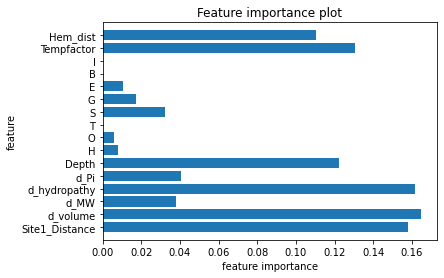

In [29]:
plot_feature_importances(tree_no_params)

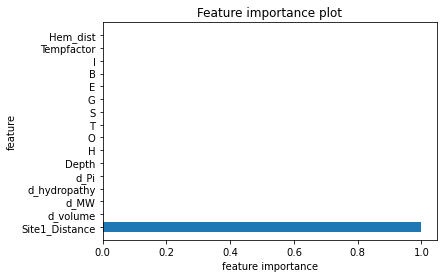

In [30]:
plot_feature_importances(tree_best_params)

In [31]:
#copy and fit classifier with best parameters from previous section
tree = tree_best_params
tree.fit(X_train_cv, y_train_cv)                 
                 
predict = tree.predict(X_test_nodup)
#generate confusion matrix
confusion = confusion_matrix(y_test_nodup, predict)

print ('\n confusion matrix: \n', confusion)


 confusion matrix: 
 [[ 8  0  0  0  0  0  0  1]
 [ 4  0  0  0  0  0  0  8]
 [ 5  0  0  0  0  0  0  8]
 [ 1  0  0  0  0  0  0  7]
 [ 1  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  4]
 [ 5  0  0  0  0  0  0  3]
 [ 2  0  0  0  0  0  0 11]]


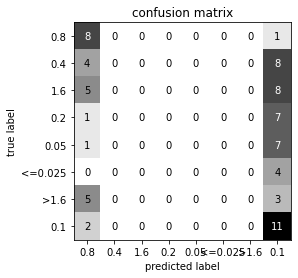

In [32]:
#generate heatmap of confusion matrix for visualisation

import mglearn

target_names = MIC_ML_data['MIC_values'].unique().tolist()
scores_image = mglearn.tools.heatmap(confusion, xlabel='predicted label',
                                     ylabel='true label', xticklabels=target_names,
                                     yticklabels=target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('confusion matrix')
plt.gca().invert_yaxis()

In [33]:
#generate classification report
from sklearn.metrics import classification_report

print (classification_report(y_test_nodup, predict, zero_division=True))

              precision    recall  f1-score   support

        0.05       0.31      0.89      0.46         9
         0.1       1.00      0.00      0.00        12
         0.2       1.00      0.00      0.00        13
         0.4       1.00      0.00      0.00         8
         0.8       1.00      0.00      0.00         8
         1.6       1.00      0.00      0.00         4
     <=0.025       1.00      0.00      0.00         8
        >1.6       0.22      0.85      0.35        13

    accuracy                           0.25        75
   macro avg       0.82      0.22      0.10        75
weighted avg       0.78      0.25      0.12        75



In [34]:
# will categorise multiclass data into 2 groups
def MIC_to_binary(data):
    RS_dict = {1:['0.2','0.4','0.8','1.6','>1.6'],
           0:['<=0.025','0.05','0.1']}
    binary_list = []
    for i in data:
        for k,v in RS_dict.items():
            for j in v:
                if i == j:
                    binary_list.append(k)

    binary_array = np.array(binary_list)
    return binary_array

In [35]:
#generate confusion matrix
confusion = confusion_matrix(MIC_to_binary(y_test_nodup), MIC_to_binary(predict))

#calculate precision, sensitivity, specificty, FPR, and errors
Precision = (confusion[1][1])/(confusion[1][1]+confusion[0][1])
Sensitivity = (confusion[1][1])/(confusion[1][1]+confusion[1][0])
Specificity = (confusion[0][0])/(confusion[0][0]+confusion[0][1])
FPR = 1-Specificity
very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


print ('Precision: ', Precision)
print ('Sensitivity: ', Sensitivity)
print ('Specificity: ', Specificity)
print ('FPR :', FPR)
print ('very major error :', very_major_error)
print ('major error: ', major_error)
print ('\n confusion matrix: \n', confusion)

Precision:  0.7551020408163265
Sensitivity:  0.8043478260869565
Specificity:  0.5862068965517241
FPR : 0.4137931034482759
very major error : inf
major error:  inf

 confusion matrix: 
 [[17 12]
 [ 9 37]]


C:\Users\user\AppData\Local\Temp/ipykernel_11004/4269136536.py:9: RuntimeWarning: divide by zero encountered in longlong_scalars
  very_major_error = (confusion[0][1]/y_test_nodup[y_test_nodup==0].count())*100
C:\Users\user\AppData\Local\Temp/ipykernel_11004/4269136536.py:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  major_error = (confusion[1][0]/y_test_nodup[y_test_nodup==1].count())*100


In [36]:
print (classification_report(MIC_to_binary(y_test_nodup), MIC_to_binary(predict)))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62        29
           1       0.76      0.80      0.78        46

    accuracy                           0.72        75
   macro avg       0.70      0.70      0.70        75
weighted avg       0.72      0.72      0.72        75

